 ## 5.3 Cross-Validation and Regularization
 
 In practical applications the ground truth function will not be given, yet we still have to find a way to balance bias and variance of our models. In order to judge these statistics, one can either keep a disjunct validation set or apply cross-validation if training data is scarce. It is also good practice to keep an additional test set, that is untouched for optimization, in order to judge future performance. The most common method against overfitting is keeping the L2-Norm of the weights as small as possible (also known as Ridge Regression for linear models). This exercise will let you explore the relationship between these concepts.

**Task a) Cross-validation and Regularization.**
  * Implement Ridge Regression for polynomial models. Don't use sklearn here!
  * Implement 3-fold cross-validation and calculate training and validation errors.
  
**Q 5.3.1: What is the effect of the regularization weight on the different evaluation statistics (training, cross-validation and test-error)?**

**Answer:** 
  * Stronger regularization increases the training error. 
  * The cross-validation error has a "sweet spot". No regularization allows for overfitting, too strong regularization leads to underfitting. Both increase the validation error.
  * The same should hold for the test error, because that is the reason to do validation in the first place. In this particular example the test set contains points that are most likely not well fitted by the polynomial model, so the error will never approach zero.
  
  The results of this exercise may vary depending on the randomly chosen datasets.

In [1]:
%%capture
%run '5.1 Bias-Variance Analysis-Solution.ipynb'
# We silently run your solution to the first exercise to have
# the previously defined functions and data available.

In [31]:
import numpy as np

n_folds = 3
n_samples = 1

# We draw the points - as before - from a sine curve
X_cv = np.array([np.random.uniform(0.1, 0.9, size=(n_samples, 1)) * (-1)**i for i in range(n_folds)])
y_cv = np.array([target(X_cv[i]) for i in range(n_folds)])

X_test = np.array([-0.97, -0.4, 0.7, 0.97]).reshape((-1, 1))
y_test = target(X_test)

Regularization weight: 0.0e+00
Average training error: 0.000
Cross-validation error: 0.358
Average test error: 1.131


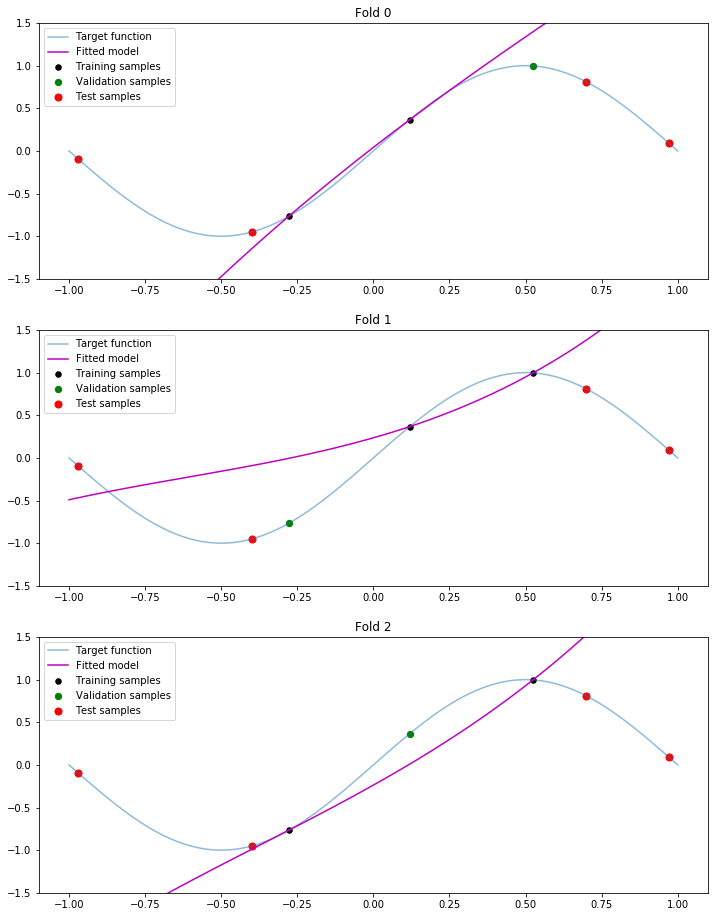

In [32]:
%matplotlib inline
import matplotlib.pyplot as plt
try: import seaborn as sns
except ImportError: pass
    
# Calculate the root mean square error
def rmse(y, y_predicted):
    return np.sqrt(np.mean(0.5 * (y - y_predicted)**2))

# TODO(Task a):
# Ridge regression is an extension of linear least squares.
# How do you have to adjust the linear fitting function for this?
# Remember to augment the dataset for polynomial features as before.
def fit_ridge_regression(X, y, regularization_weight):
    verify_shapes(X, y)
    X_aug = add_polynomials(X)
    
    # This is the new part. It adds a weighted identity term to the data matrix
    # Add an epsilon to make inversion stable
    regularization_term = (1e-10 + regularization_weight) * np.eye(X_aug.shape[1])
    
    inverse = np.linalg.pinv(regularization_term + X_aug.T.dot(X_aug))

    return inverse.dot(X_aug.T).dot(y)
    

# Bookkeeping
training_errors = np.zeros((n_folds))
validation_errors = np.zeros((n_folds))
test_errors = np.zeros((n_folds))
models = np.zeros((n_folds, poly_degree + 1, 1))

# Here we define our cross-validation function specialized for
# our ridge regression models. The regularization weight is
# the only hyperparameter.
def cross_validate(regularization_weight):
    
    # Loop over the validation folds
    for i in range(n_folds):
        
        # Split the data into training and validation set
        # You can use the mask to select the correct training folds
        mask = np.arange(n_folds) != i
        
        # We need to reshape afterwards to get them into the correct
        # form of (n_samples, n_features)
        X_train = X_cv[mask].reshape((-1, 1))
        y_train = y_cv[mask].reshape((-1, 1))
        verify_shapes(X_train, y_train)
    
        # The validation set is now the part we did not select for training
        X_valid = X_cv[i]
        y_valid = y_cv[i]
        verify_shapes(X_valid, y_valid)
    
        # Train a model and determine the training and validation error
        # Luckily we wrote a function for this
        models[i] = fit_ridge_regression(X_train, y_train,
                                         regularization_weight)
        
        # Calculate the training, validation and test error
        # for the model trained in this fold
        # The models can be evaluated with the predict_polynomial function
        # from the first part. We already wrote an error function
        # for comparing it to the ground truth
        training_errors[i] = rmse(y_train, predict_polynomial(X_train, models[i]))
        validation_errors[i] = rmse(y_valid, predict_polynomial(X_valid, models[i]))
        test_errors[i] = rmse(y_test, predict_polynomial(X_test, models[i]))
            
    # Calculate the statistics for the whole procedure
    # This reduces to taking the mean over the folds
    # The cross-validation error is the measure we're after!
    avg_training_error = np.mean(training_errors)
    cross_validation_error = np.mean(validation_errors)
    avg_test_error = np.mean(test_errors)

    return avg_training_error, cross_validation_error, avg_test_error
    
# Set the strength of the regularisation here
regularization_weight = 0.0
avg_training_error, cross_validation_error, avg_test_error = \
    cross_validate(regularization_weight)

# Show the statistics for this model class
print('Regularization weight: {:.1e}'.format(regularization_weight))
print('Average training error: {:.3f}'.format(avg_training_error))
print('Cross-validation error: {:.3f}'.format(cross_validation_error))
print('Average test error: {:.3f}'.format(avg_test_error))

# Plotting: For 3 folds, we can still look at each model and how
# well it fits the different data sets.
fix, axes = plt.subplots(n_folds, 1, figsize=(12, 16))
X_eval = np.linspace(-1, 1, 200).reshape((-1, 1))
y_eval = np.sin(np.pi * X_eval)
for i, axis in enumerate(axes):
    axis.set_title('Fold {:d}'.format(i))
    axis.plot(X_eval, np.sin(np.pi * X_eval), label='Target function', alpha=0.5)
    if not np.any(np.isnan(models[i])):
        axis.plot(X_eval, predict_polynomial(X_eval, models[i]),
                  label='Fitted model', c='m')
    mask = np.arange(n_folds) != i
    axis.scatter(X_cv[mask].flatten(), y_cv[mask].flatten(),
                 label='Training samples', s=30, c='k')
    axis.scatter(X_cv[i].flatten(), y_cv[i].flatten(),
                 label='Validation samples', s=40, c='g')
    axis.scatter(X_test.flatten(), y_test.flatten(),
                 label='Test samples', s=50, c='r')
    axis.set_xlim((-1.1, 1.1))
    axis.set_ylim((-1.5, 1.5))
    axis.legend(loc='best')